In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Description

In [3]:
df = pd.read_csv("assign.csv")
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,y
0,36,blue-collar,married,middle,no,yes,may,cell,239,1,999,0,-1.8,92.893,-46.2,1.344,5099.1,False
1,39,blue-collar,married,middle,yes,no,nov,NaN,124,1,999,0,-0.1,93.200,-42.0,4.076,5195.8,False
2,31,services,single,middle,no,no,may,cell,163,1,999,0,-1.8,92.893,-46.2,1.344,5099.1,False
3,35,technician,married,professional,yes,no,jul,cell,157,8,999,0,1.4,93.918,-42.7,4.962,5228.1,False
4,38,blue-collar,married,middle,yes,no,may,phone,275,6,999,0,1.1,93.994,-36.4,4.856,5191.0,False


In [5]:
df.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,y
39995,26,unemployed,married,high,yes,no,jul,cell,474,7,999,0,-1.7,94.215,-40.3,0.822,4991.6,True
39996,59,unemployed,married,professional,yes,no,aug,cell,378,2,999,1,-2.9,92.201,-31.4,0.881,5076.2,False
39997,23,self-employed,single,middle,yes,no,may,cell,64,2,999,0,-1.8,92.893,-46.2,1.266,5099.1,False
39998,33,technician,married,high,no,no,apr,cell,211,2,999,1,-1.8,93.075,-47.1,1.405,5099.1,False
39999,44,management,married,university,yes,no,nov,cell,176,1,999,0,-0.1,93.200,-42.0,4.076,5195.8,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      40000 non-null  int64  
 1   x2      40000 non-null  object 
 2   x3      40000 non-null  object 
 3   x4      40000 non-null  object 
 4   x5      40000 non-null  object 
 5   x6      40000 non-null  object 
 6   x7      40000 non-null  object 
 7   x8      39994 non-null  object 
 8   x9      40000 non-null  int64  
 9   x10     40000 non-null  int64  
 10  x11     40000 non-null  int64  
 11  x12     40000 non-null  int64  
 12  x13     40000 non-null  float64
 13  x14     39992 non-null  float64
 14  x15     40000 non-null  float64
 15  x16     40000 non-null  float64
 16  x17     40000 non-null  float64
 17  y       40000 non-null  bool   
dtypes: bool(1), float64(5), int64(5), object(7)
memory usage: 5.2+ MB


In [6]:
df.describe()

,x1,x9,x10,x11,x12,x13,x14,x15,x16,x17
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,39992.000000,40000.000000,40000.000000,40000.000000
mean,40.012200,258.721825,2.566375,962.110625,0.173075,0.081885,93.576081,-40.501568,3.621611,5167.021655
std,10.416123,260.258055,2.771441,187.806197,0.495758,1.570986,0.578954,4.627286,1.734336,72.249786
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,320.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


# Data Preprocessing
Before we process the data, we need to know what is the null value inside the dataset. Now we are examine what null value is inside in categorical data.

In [7]:
print(df['x2'].value_counts())

admin            10130
blue-collar       8995
technician        6565
services          3843
management        2837
retired           1666
entrepreneur      1406
self-employed     1387
housemaid         1025
unemployed         984
student            843
unknown            319
Name: x2, dtype: int64


In [8]:
print(df['x3'].value_counts())

married     24172
single      11270
divorced     4480
unknown        78
Name: x3, dtype: int64


In [9]:
print(df['x4'].value_counts())

university      11820
high             9254
primary          6289
middle           5856
professional     5080
unknown          1684
illiterate         17
Name: x4, dtype: int64


In [10]:
print(df['x5'].value_counts())

yes        20952
no         18086
unknown      962
Name: x5, dtype: int64


In [11]:
print(df['x6'].value_counts())

no         32936
yes         6102
unknown      962
Name: x6, dtype: int64


In [12]:
print(df['x7'].value_counts())

may    13393
jul     6967
aug     5978
jun     5172
nov     3988
apr     2545
oct      696
sep      553
mar      532
dec      176
Name: x7, dtype: int64


In [15]:
print(df['x8'].value_counts())

cell     25356
phone    14638
Name: x8, dtype: int64


Now we can conclude that null value will include NaN and unknown for categorical data. Besides, there will have NaN value for x13 for numerical data. So we need to tell pandas to treat these values as null value.

In [17]:
na_values = ['NaN', "unknown"]
na_values = ['NaN', "unknown"]
data = pd.read_csv("assign.csv", na_values=na_values)

In [19]:
data.isnull().sum()

x1        0
x2      319
x3       78
x4     1684
x5      962
x6      962
x7        0
x8        6
x9        0
x10       0
x11       0
x12       0
x13       0
x14       8
x15       0
x16       0
x17       0
y         0
dtype: int64

<AxesSubplot:>

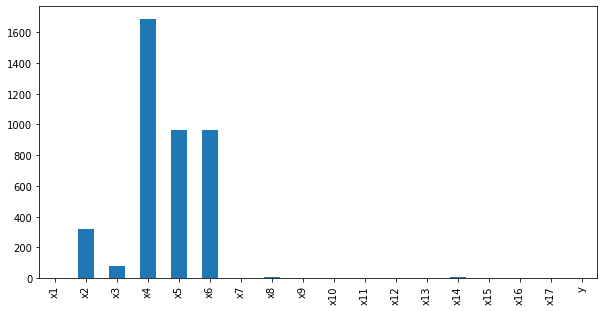

In [18]:
data.isnull().sum().plot(kind='bar', figsize=(10, 5))

In [20]:
median = data['x14'].median()
data['x14'].fillna(median, inplace=True)

In [22]:
# most frequently value for x3
data.mode().loc[:,['x2', 'x3', 'x4', 'x5', 'x6', 'x8']]

,x2,x3,x4,x5,x6,x8
0,admin,married,university,yes,no,cell


In [23]:
# Fill x3, x2, x8 with most frequently occuring value
data['x2'].fillna("admin", inplace=True)
data['x3'].fillna("married", inplace=True)
data['x4'].fillna("university", inplace=True)
data['x5'].fillna("yes", inplace=True)
data['x6'].fillna("no", inplace=True)
data['x8'].fillna("cell", inplace=True)

<AxesSubplot:xlabel='x11', ylabel='count'>

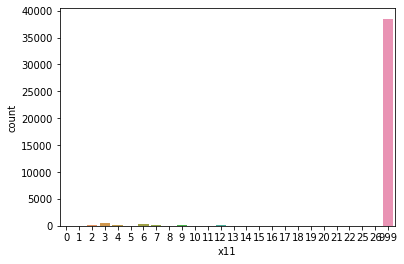

In [25]:
sns.countplot(x="x11", data=data)

In [26]:
# Since there are only 3 percent of data that is not 999.
# Therefore, this column doesn't have any value for modeling.
data['x11'][data['x11'] != 999].count() / data['x11'][data['x11'] == 999].count()

0.03858337228020979

In [27]:
data.drop("x11", axis=1, inplace=True)

# Data visualization

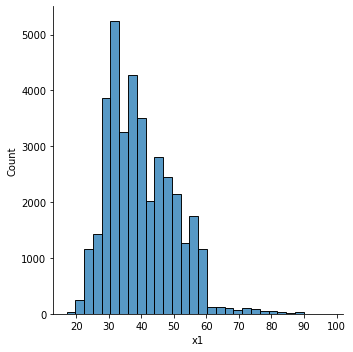

In [21]:
sns.displot(data['x1'], bins=30)

In [23]:
data['x2'].value_counts()

admin            9858
blue-collar      8330
technician       6223
services         3604
management       2650
retired          1529
self-employed    1321
entrepreneur     1318
housemaid         957
unemployed        940
student           664
Name: x2, dtype: int64

In [84]:
data['x3'].value_counts()

married     22667
single      10542
divorced     4185
Name: x3, dtype: int64

In [85]:
data['x4'].value_counts()

university      11555
high             9040
primary          6116
middle           5710
professional     4956
illiterate         17
Name: x4, dtype: int64

<AxesSubplot:xlabel='x5', ylabel='count'>

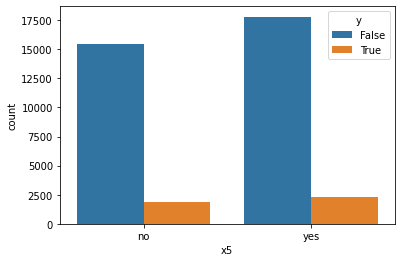

In [86]:
sns.countplot(data=data, x='x5', hue='y')

In [87]:
data['x8'].value_counts()

cell     23846
phone    13548
Name: x8, dtype: int64

/home/jinyee/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='x17', ylabel='Density'>

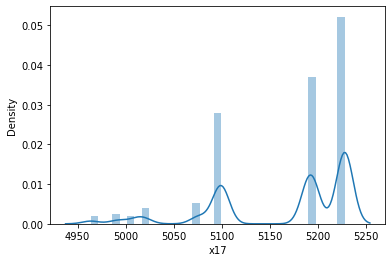

In [88]:
# plot x17 with distplot
sns.distplot(data['x17'])

<AxesSubplot:xlabel='y', ylabel='count'>

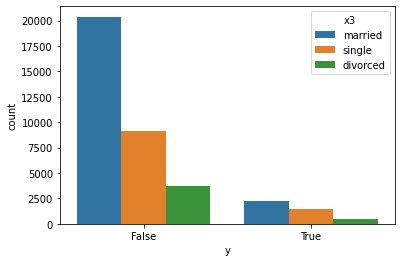

In [89]:
sns.countplot(x='y', hue='x3',data=data)

<AxesSubplot:xlabel='y', ylabel='count'>

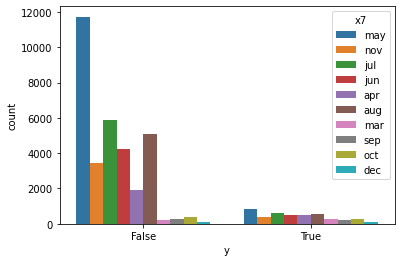

In [90]:
sns.countplot(x='y', hue='x7',data=data)

<AxesSubplot:xlabel='x11', ylabel='count'>

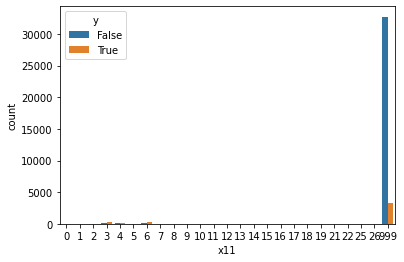

In [24]:
sns.countplot(x="x11", hue="y", data=data)

/home/jinyee/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='x17'>

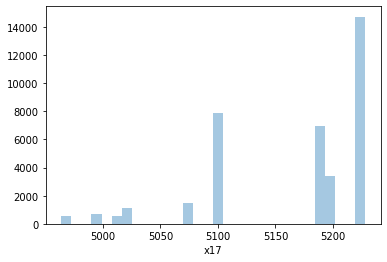

In [92]:
sns.distplot(data["x17"].dropna(), kde=False, bins=30)

/home/jinyee/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='x16'>

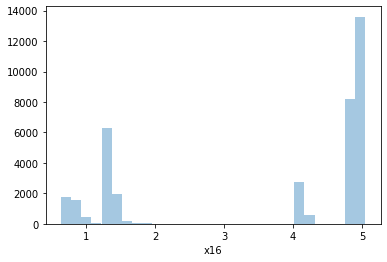

In [93]:
sns.distplot(data["x16"].dropna(), kde=False, bins=30)

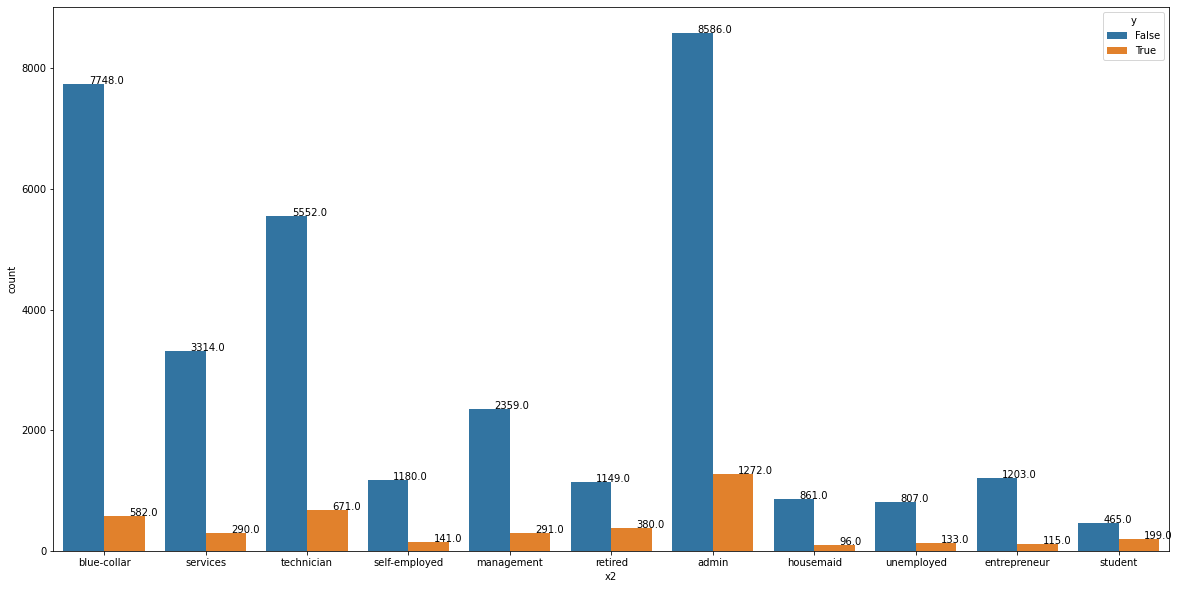

In [94]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='x2', hue='y',data=data)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

<AxesSubplot:xlabel='x3', ylabel='x17'>

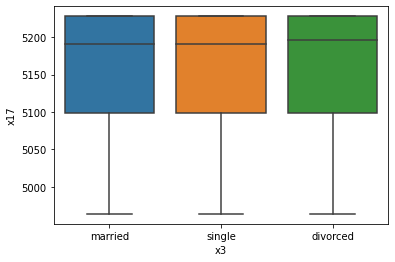

In [95]:
sns.boxplot(x='x3', y='x17', data=data)

<AxesSubplot:xlabel='x4', ylabel='x17'>

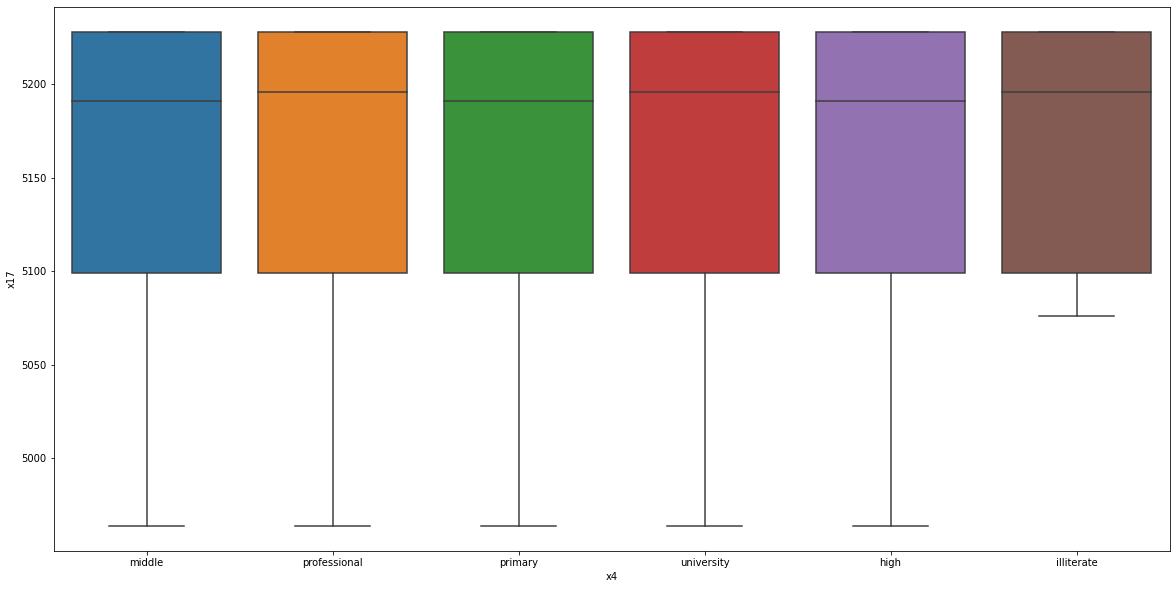

In [96]:
plt.figure(figsize=(20,10))
sns.boxplot(x='x4', y='x17', data=data)

<AxesSubplot:xlabel='x4', ylabel='x1'>

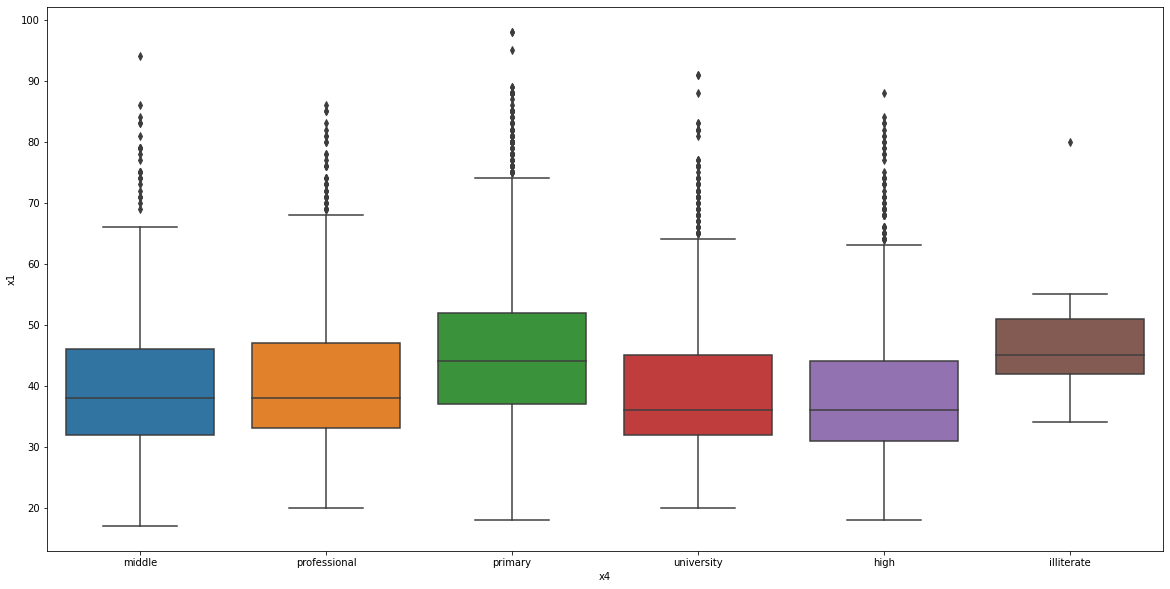

In [97]:
plt.figure(figsize=(20,10))
sns.boxplot(x='x4', y='x1', data=data)

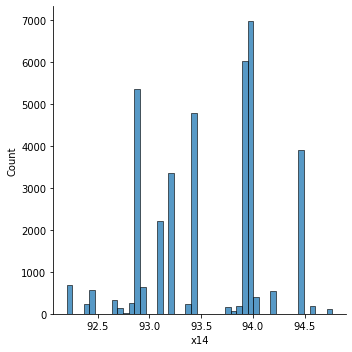

In [98]:
sns.displot(data=data, x="x14")

<AxesSubplot:xlabel='x2', ylabel='x14'>

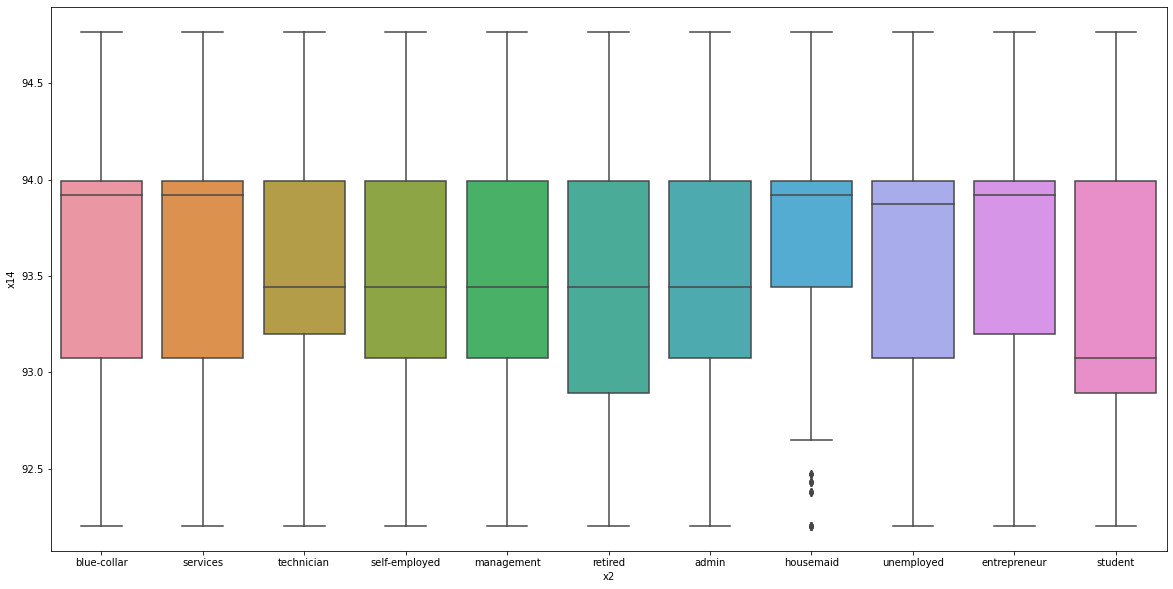

In [99]:
plt.figure(figsize=(20,10))
sns.boxplot(data=data, y="x14", x="x2")

<AxesSubplot:xlabel='x3', ylabel='x14'>

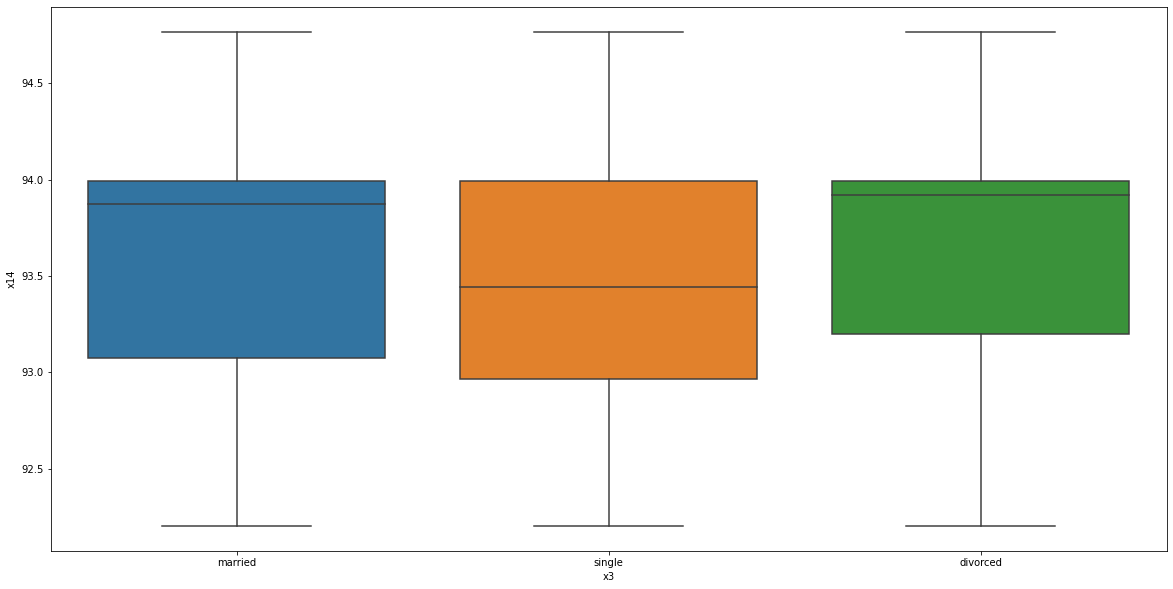

In [100]:
plt.figure(figsize=(20,10))
sns.boxplot(data=data, y="x14", x="x3")

<AxesSubplot:xlabel='x4', ylabel='x14'>

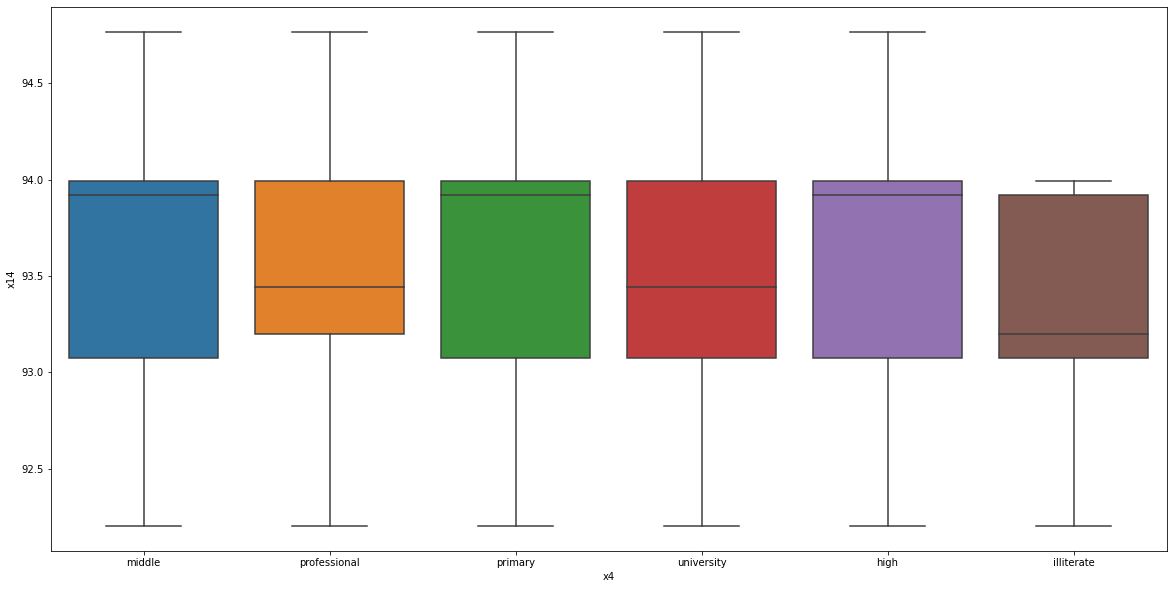

In [101]:
plt.figure(figsize=(20,10))
sns.boxplot(data=data, y="x14", x="x4")

# Data Preprocessing

class 0: (33224, 18)
class 1: (4170, 18)
False    4170
True     4170
Name: y, dtype: int64


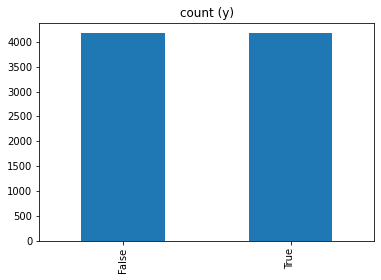

In [102]:
class_count_0, class_count_1 = data['y'].value_counts()
class_0 = data[data['y'] == 0]
class_1 = data[data['y'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)
print(test_under['y'].value_counts())
test_under['y'].value_counts().plot(kind='bar', title='count (y)')
test_under.head(20)
data = test_under


In [103]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

In [104]:
mean = data['x14'].mean()
data['x14'].fillna(mean, inplace=True)
data.dropna(subset=['x8', 'x2', 'x3', 'x4', 'x5', 'x6'], inplace=True)
# data.drop('x11', axis=1, inplace=True)
data.isnull().sum()

x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
x14    0
x15    0
x16    0
x17    0
y      0
dtype: int64

In [105]:
x2_cat = data[['x2']]
x3_cat = data[['x3']]
x4_cat = data[['x4']]
x5_cat = data[['x5']]
x6_cat = data[['x6']]
x7_cat = data[['x7']]
x8_cat = data[['x8']]

In [106]:
x2_cat_encoded = catx2_encoder.fit_transform(x2_cat)
x2_cat_encoded.toarray()
catx2_encoder.categories_
data.head()

NameError: name 'catx2_encoder' is not defined

In [ ]:
x3_cat_encoded = catx3_encoder.fit_transform(x3_cat)
x3_cat_encoded.toarray()
catx3_encoder.categories_

[array(['divorced', 'married', 'single'], dtype=object)]

In [ ]:
# Tansform x4, x5,x6, x7, x8
x4_cat_encoded = catx4_encoder.fit_transform(x4_cat)
x4_cat_encoded.toarray()
catx4_encoder.categories_

x5_cat_encoded = catx5_encoder.fit_transform(x5_cat)
x5_cat_encoded.toarray()
catx5_encoder.categories_

x6_cat_encoded = catx6_encoder.fit_transform(x6_cat)
x6_cat_encoded.toarray()
catx6_encoder.categories_

x7_cat_encoded = catx7_encoder.fit_transform(x7_cat)
x7_cat_encoded.toarray()
catx7_encoder.categories_

x8_cat_encoded = catx8_encoder.fit_transform(x8_cat)
x8_cat_encoded.toarray()
catx8_encoder.categories_

data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,y
16954,42,technician,married,professional,no,no,nov,cell,212,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,False
35348,32,admin,married,university,yes,no,jun,phone,65,2,999,0,1.4,94.465,-41.8,4.959,5228.1,False
4214,50,technician,married,university,yes,yes,sep,cell,1353,2,999,0,-3.4,92.379,-29.8,0.749,5017.5,False
18223,44,admin,divorced,high,yes,no,aug,cell,99,2,999,0,1.4,93.444,-36.1,4.970,5228.1,False
20036,42,admin,single,high,no,yes,jul,cell,295,1,999,0,1.4,93.918,-42.7,4.962,5228.1,False


In [ ]:
data_num = data.select_dtypes(include=[np.number])
data_num.head()
data_num.corr(method='pearson')

,x1,x9,x10,x11,x12,x13,x14,x15,x16,x17
x1,1.000000,-0.019880,-0.000749,-0.072673,0.070645,-0.056830,-0.020557,0.133247,-0.054049,-0.083742
x9,-0.019880,1.000000,-0.020975,0.035656,-0.047998,0.074919,0.059132,-0.063119,0.060398,0.065808
x10,-0.000749,-0.020975,1.000000,0.086414,-0.100402,0.202908,0.134415,-0.023040,0.190896,0.192091
x11,-0.072673,0.035656,0.086414,1.000000,-0.711335,0.333811,0.040199,-0.156775,0.383550,0.469358
x12,0.070645,-0.047998,-0.100402,-0.711335,1.000000,-0.385320,-0.061151,0.077936,-0.448867,-0.524523
x13,-0.056830,0.074919,0.202908,0.333811,-0.385320,1.000000,0.721103,-0.045055,0.958738,0.867996
x14,-0.020557,0.059132,0.134415,0.040199,-0.061151,0.721103,1.000000,-0.145733,0.573430,0.347940
x15,0.133247,-0.063119,-0.023040,-0.156775,0.077936,-0.045055,-0.145733,1.000000,0.062662,-0.070648
x16,-0.054049,0.060398,0.190896,0.383550,-0.448867,0.958738,0.573430,0.062662,1.000000,0.939724
x17,-0.083742,0.065808,0.192091,0.469358,-0.524523,0.867996,0.347940,-0.070648,0.939724,1.000000


In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])
data_num_tr = num_pipeline.fit_transform(data_num)

In [ ]:
from sklearn.compose import ColumnTransformer
num_attribs = list(data_num)
cat_attribs = ["x2", "x3", "x4", "x5", "x6", "x7", "x8"]
num_train = data.drop("y", axis=1)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(categories='auto', drop='first', sparse=False), cat_attribs),
    ])
data_prepared = full_pipeline.fit_transform(num_train)

In [ ]:
data_prepared

array([[ 0.13881415, -0.49155994, -0.5756336 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.70616815, -0.89700766, -0.14307294, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.81479999,  2.65548669, -0.14307294, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.62166992,  0.47654994, -0.5756336 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.29765577, -0.85011915, -0.5756336 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.21315754,  0.23107479,  2.01973039, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
data_prepared.shape

(8284, 39)

# Model training and validation

In [ ]:
# import train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_prepared, data['y'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(max_iter=5000, random_state=42)

In [ ]:
predictions = sgd_clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.85      0.84      0.85       833
        True       0.84      0.85      0.85       824

    accuracy                           0.85      1657
   macro avg       0.85      0.85      0.85      1657
weighted avg       0.85      0.85      0.85      1657



In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

[[703 130]
 [124 700]]


# Model Fine Tuning and Testing